In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.csv.xls to data.csv.xls


Original number of rows: 4600
Original columns: ['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country']

Cleaned data rows: 3757
              price  sqft_living     bedrooms    bathrooms
count  3.757000e+03  3757.000000  3757.000000  3757.000000
mean   4.731519e+05  1926.822199     3.316210     2.049241
min    7.800000e+03   370.000000     1.000000     0.750000
25%    3.100000e+05  1390.000000     3.000000     1.500000
50%    4.370000e+05  1850.000000     3.000000     2.000000
75%    5.973260e+05  2380.000000     4.000000     2.500000
max    1.150000e+06  4130.000000     9.000000     5.750000
std    2.074133e+05   706.241941     0.869606     0.690970


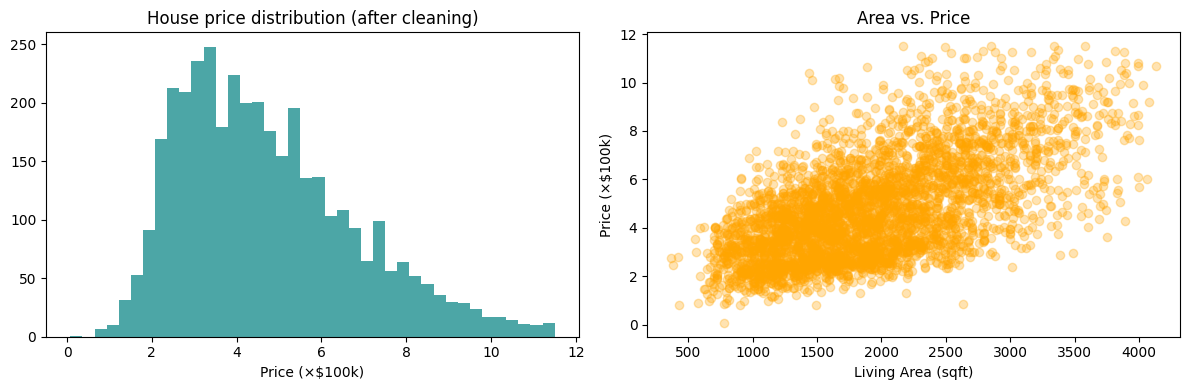


Data cleaning completed.


In [ ]:
# Preprocessing of housing price data (removing extreme values and unreasonable records)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


path = "data.csv.xls"
df = pd.read_csv(path, encoding_errors="ignore")

print("Original number of rows:", len(df))
print("Original columns:", df.columns.tolist())

df = df.dropna(subset=['price', 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built'])

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['zip'] = df['statezip'].astype(str).str.split().str[-1]


df = df[df['bedrooms'] > 0]
df = df[df['bathrooms'] > 0]
df = df[(df['sqft_living'] > 100) & (df['sqft_lot'] > 100)]
df = df[(df['floors'] > 0) & (df['floors'] <= 4)]
df = df[df['yr_built'] >= 1900]
df = df[df['price'] > 0]

def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

df = remove_outliers(df, 'price')
df = remove_outliers(df, 'sqft_living')
df = remove_outliers(df, 'sqft_lot')


print("\nCleaned data rows:", len(df))
print(df.describe()[['price','sqft_living','bedrooms','bathrooms']])


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df['price']/1e5, bins=40, color='teal', alpha=0.7)
plt.xlabel('Price (×$100k)')
plt.title('House price distribution (after cleaning)')

plt.subplot(1,2,2)
plt.scatter(df['sqft_living'], df['price']/1e5, alpha=0.3, color='orange')
plt.xlabel('Living Area (sqft)')
plt.ylabel('Price (×$100k)')
plt.title('Area vs. Price')
plt.tight_layout()
plt.show()


df.to_csv("cleaned_data.csv", index=False)
print("\nData cleaning completed.")


Loaded cleaned data with 3757 records.
Training samples: 3078，Testing samples: 679

MTL Model Evaluation
RMSE : 109,859.86
MAE  : 74,304.72
R²   : 0.7273
MAPE : 17.69%


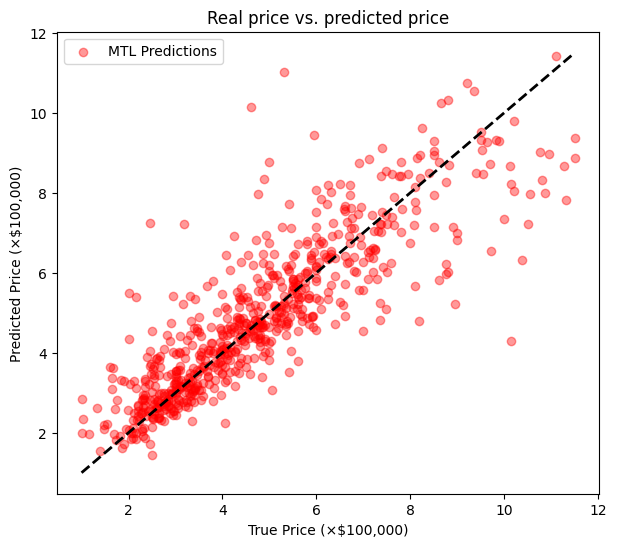

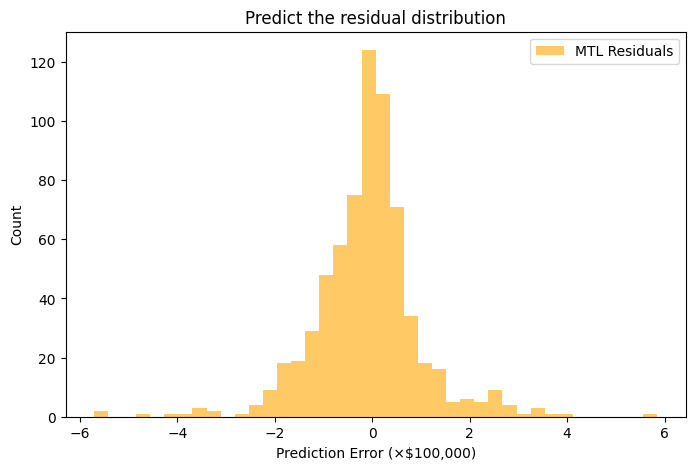

In [ ]:
!pip install scikit-learn pandas matplotlib --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso

df = pd.read_csv("cleaned_data.csv")
print("Loaded cleaned data with", len(df), "records.")


df['date'] = pd.to_datetime(df['date'])
target = 'price'
num_features = [
    'bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
    'view','condition','sqft_above','sqft_basement','yr_built','yr_renovated',
    'year','month'
]
cat_features = ['city']
tasks = df['zip'].astype(str)

X_num = df[num_features].copy()
X_all = df[num_features + cat_features].copy()
y = df[target].astype(float)

# Split train/test by time
df_sorted = df.sort_values('date').reset_index(drop=True)
cut = int(len(df_sorted) * 0.8)
cutoff_date = df_sorted.loc[cut, 'date']

train_mask = df['date'] <= cutoff_date
Xnum_tr, Xnum_te = X_num[train_mask], X_num[~train_mask]
Xall_tr, Xall_te = X_all[train_mask], X_all[~train_mask]
y_tr, y_te = y[train_mask], y[~train_mask]
tasks_tr, tasks_te = tasks[train_mask], tasks[~train_mask]

print(f"Training samples: {len(Xnum_tr)}，Testing samples: {len(Xnum_te)}")

# Shared layer: Global Lasso
pre = ColumnTransformer([
    ("num", "passthrough", num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])
global_model = Pipeline([
    ("pre", pre),
    ("reg", Lasso(alpha=1e4, max_iter=20000))
])
global_model.fit(Xall_tr, y_tr)
pred_global_train = global_model.predict(Xall_tr)
pred_global_test = global_model.predict(Xall_te)

# Task-specific layer: per-ZIP Ridge residual model
residual_models = {}
residual_train = y_tr - pred_global_train

for z in tasks_tr.unique():
    idx = (tasks_tr == z)
    if idx.sum() < 20:
        continue
    Xi, ri = Xnum_tr[idx], residual_train[idx]
    model = Ridge(alpha=500.0)
    model.fit(Xi, ri)
    residual_models[z] = model

# Prediction on test data
pred_mtl = np.zeros_like(y_te.values, dtype=float)
for i in range(len(Xnum_te)):
    base = pred_global_test[i]
    z = tasks_te.iloc[i]
    rmod = residual_models.get(z)
    if rmod is not None:
        base += rmod.predict(Xnum_te.iloc[[i]])[0]
    pred_mtl[i] = base

# Model evaluation
from sklearn.metrics import r2_score

def rmse(y_true, y_pred):
    return math.sqrt(np.mean((y_true - y_pred) ** 2))

rmse_value = rmse(y_te, pred_mtl)
mae_value = mean_absolute_error(y_te, pred_mtl)
r2_value = r2_score(y_te, pred_mtl)
mape_value = np.mean(np.abs((y_te - pred_mtl) / y_te)) * 100

print("\nMTL Model Evaluation")
print(f"RMSE : {rmse_value:,.2f}")
print(f"MAE  : {mae_value:,.2f}")
print(f"R²   : {r2_value:.4f}")
print(f"MAPE : {mape_value:.2f}%")

# Save prediction results
out = pd.DataFrame({
    "date": df[~train_mask]['date'].values,
    "zip": tasks_te.values,
    "city": df[~train_mask]['city'].values,
    "price_true": y_te.values,
    "price_pred_MTL": pred_mtl
})
out.to_csv("MTL_predictions_aligned.csv", index=False)


# Visualization
y_te_scaled = y_te / 1e5
pred_mtl_scaled = pred_mtl / 1e5

plt.figure(figsize=(7,6))
plt.scatter(y_te_scaled, pred_mtl_scaled, alpha=0.4, color="red", label="MTL Predictions")
plt.plot([y_te_scaled.min(), y_te_scaled.max()],
         [y_te_scaled.min(), y_te_scaled.max()], 'k--', lw=2)
plt.xlabel("True Price (×$100,000)")
plt.ylabel("Predicted Price (×$100,000)")
plt.title("Real price vs. predicted price")
plt.legend()
plt.show()


plt.figure(figsize=(8,5))
plt.hist((y_te - pred_mtl)/1e5, bins=40, alpha=0.6, color="orange", label="MTL Residuals")
plt.xlabel("Prediction Error (×$100,000)")
plt.ylabel("Count")
plt.title("Predict the residual distribution")
plt.legend()
plt.show()

